#  Break Haario Bardenet ACMC on a 2 dimensional Gaussian distribution by accepting proposal with some probability regardless of score

In this notebook, we deliberately break The Haario Bardenet ACMC sampler by causing it to incorrectly accept proposals with a certain probability. The sampler is used on the 1D Gaussian distribution.

## Define broken sampler

In [5]:
class BrokenHaarioBardenetACMC(pints.HaarioBardenetACMC):
    """Broken version of Metropolis Hastings.

    At each MH step, with probability given by error_freq, it will always
    accept the proposal.
    """
    def __init__(self, x0, sigma0=None):
        super().__init__(x0, sigma0)
        self.error_freq = 0.0

    def set_error_freq(self, error_freq):
        self.error_freq = error_freq

    def tell(self, fx):
        if self.error_freq == 0.0 or random.random() > self.error_freq:
            # Run MH step correctly
            return super().tell(fx)
        else:
            # Always accept it even if it is bad
            self._acceptance = ((self._iterations * self._acceptance + 1) /
                                (self._iterations + 1))
            self._iterations += 1
            self._current = self._proposed
            self._current_log_pdf = fx
            self._proposed = None
            return self._current

## Changepoint detection with hyperparameters I (marginal Rhat criterion)

We desire marginal $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. The corresponing hyperparameters were found in the baseline notebook to be

1. Number of chains: 3
2. Number of iterations: 4000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default

### Compute Kullback-Leibler divergence for 15 unbroken and 15 broken posteriors

In [ ]:
#TODO
def get_klds(num_runs, start_breaking, error_freq):
    """Run MCMC multiple times, break at some point, and get the KL divs.
    
    It uses the BrokenMH sampler and the 1D Gaussian distribution.

    Parameters
    ----------
    num_runs : int
        Total number of runs
    start_breaking : int
        Which run to break the MCMC algorithm
    error_freq : float
        Error probability per MH step once the algorithm is broken

    Returns
    -------
    list
        List of kl divergences from samples to posterior for each run
    """
    posterior = NormalDist(np.array([1.0]), np.array([0.1**2]))
    x0 = [np.array([1.0])]

    klds = []
    for run in range(num_runs):
        mcmc = pints.MCMCController(posterior, 1, x0, method=BrokenMH)
        mcmc.set_max_iterations(1000)
        if run >= start_breaking:
            for s in mcmc.samplers():
                s.set_error_freq(error_freq)

        mcmc.set_log_to_screen(False)
        chains = mcmc.run()
        kld = posterior.kl_divergence(chains[0])
        klds.append(kld)

    return klds

In [3]:
import pints
import pints.toy

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=3),
    pints.GaussianLogPrior(mean=0, sd=3))

# Set up hyperparameters
n_chains = 3
initial_parameters = log_prior.sample(n=n_chains)
n_iterations = 4000
method = pints.HaarioBardenetACMC
is_run_parallel = True

# Set up problem
sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

# Sample
chains = sampler.run()

### Visualise traces

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------
param 1  -0.03   1.02    -2.08   -0.68  0.00   0.65   2.02     1.00    858.70
param 2  -0.00   0.99    -1.87   -0.71  -0.02  0.67   1.93     1.00    960.10


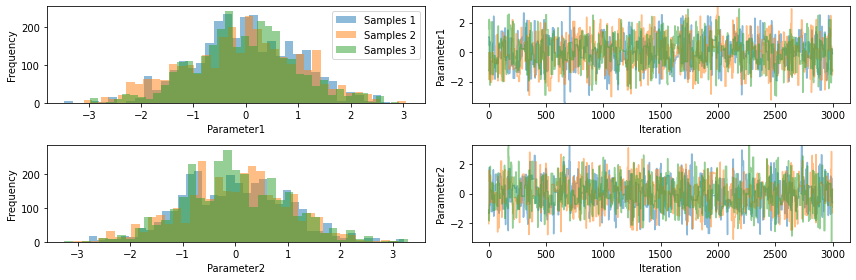

In [4]:
import matplotlib.pyplot as plt
import pints.plot

# Set warmup iterations
warmup = 1000

# Show summary
print(pints.MCMCSummary(chains=chains[:, warmup:]))

# Plot traces
fig = pints.plot.trace(chains[:, warmup:])
plt.show()

### Visualise $\hat{R}$ and ESS over length of chains

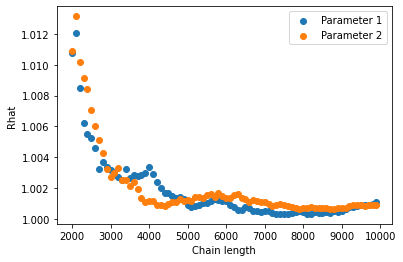

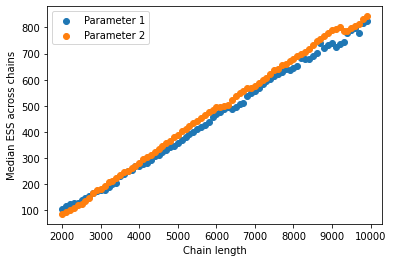

In [3]:
import numpy as np

# Define chain lengths for Rhat evaluation
warmup = 1000
chain_lengths = np.arange(start=2000, stop=10000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = pints.rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.legend()
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

### Reduce the number of chains

The desired ESS is reached after 3000 iterations (plus initial 1000 iterations warmup). The Rhat is well below 1.01, so we may use fewer chains.

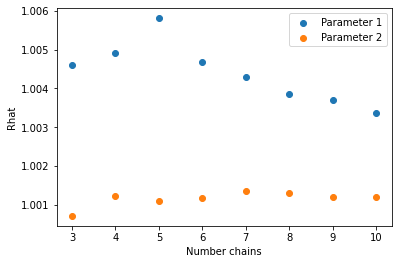

In [4]:
# Get relevant chain lengths
warmup = 1000
chain_length = 4000
cleaned_chains = chains[:, warmup:chain_length]

# Define number of chains to explore
number_chains = np.arange(start=3, stop=n_chains+1)

# Compute rhat
n_parameters = 2
rhats = np.empty(shape=(len(number_chains), n_parameters))
for _id, n in enumerate(number_chains):
    # Compute rhat for chains
    reduced_chains = cleaned_chains[:n]
    rhats[_id] = pints.rhat(reduced_chains)
    
# Plot evolution of rhat
plt.scatter(x=number_chains, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=number_chains, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Number chains')
plt.ylabel('Rhat')
plt.legend()
plt.show()

### Conclusion on hyperparameters

We desire marginal $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. This suggests the following hyperparameters to satisfy these conditions

1. Number of chains: 3
2. Number of iterations: 4000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default

## Hyperparameters I: Multivariate $\hat{R} < 1.01$ and an effective sample size per parameter $>200$ per chain.

In [5]:

def _within(chains):
    # Get number of chains and number of parameters
    n_chains, _, n_parameters = chains.shape

    # Compute unbiased within-chain covariance estimate
    within_chain_cov = np.empty(shape=(n_chains, n_parameters, n_parameters))
    for chain_id, chain in enumerate(chains):
        within_chain_cov[chain_id] = np.cov(chain, ddof=1, rowvar=False)

    # Compute mean-within chain variance
    w = np.mean(within_chain_cov, axis=0)

    return w

def _between(chains):
    # Get number of samples
    n = chains.shape[1]

    # Compute within-chain mean
    within_chain_means = np.mean(chains, axis=1)

    # Compute covariance across chains of within-chain means
    between_chain_cov = np.cov(within_chain_means, ddof=1, rowvar=False)

    # Weight variance with number of samples per chain
    b = n * between_chain_cov

    return b

def multidimensional_rhat(chains):
    # Get number of samples
    n = chains.shape[1]

    # Split chains in half
    n = n // 2  # new length of chains
    if n < 1:
        raise ValueError(
            'Number of samples per chain after warm-up and chain splitting is '
            '%d. Method needs at least 1 sample per chain.' % n)
    chains = np.vstack([chains[:, :n], chains[:, -n:]])

    # Compute mean within-chain covariance
    w = _within(chains)

    # Compute mean between-chain convariance
    b = _between(chains)

    # Compute Rhat
    rhat = np.sqrt((n - 1.0) / n + np.linalg.det(b) / (np.linalg.det(w) * n))

    return rhat

### Visualise $\hat{R}$ and ESS over number of iterations

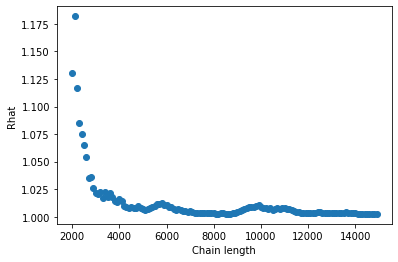

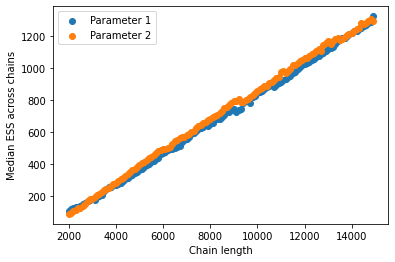

In [6]:
import numpy as np

# Define chain lengths for Rhat evaluation
warmup = 1000
chain_lengths = np.arange(start=2000, stop=15000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=n_lengths)
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = multidimensional_rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats)
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

### Conclusion on hyperparameters

We desire a multivariate $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. This suggests the following hyperparameters to satisfy these conditions

1. Number of chains: 10
2. Number of iterations: 10000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default